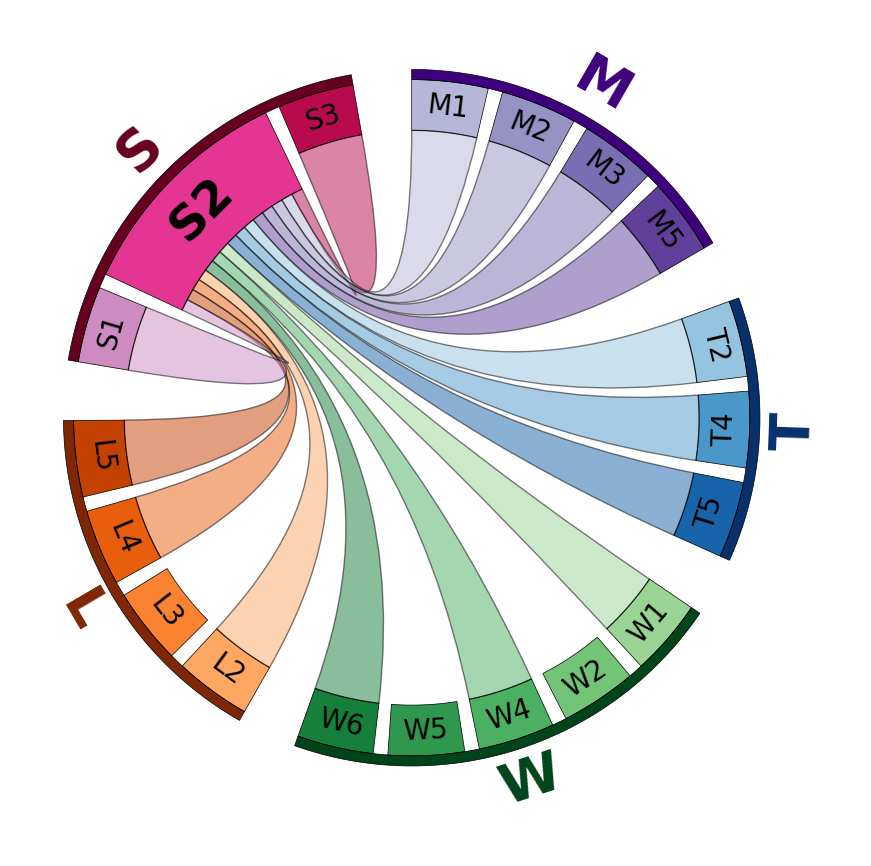

In [2]:
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
sect_w=5
sect_fac=3 # increase sector size of main subtopic
do_usedeadsubt=False


# this is your subtopic
subt_name        = 'S2'
# this is a list of connection to the other subtopics
subt_conect_list = ['S1', 'S3', 'M1', 'M2', 'M3', 'M5', 'T2', 'T4', 'T5', 'W1', 'W4', 'W6', 'L2', 'L4', 'L5']

# # this is your subtopic
# subt_name        = 'M5'
# # this is a list of connection to the other subtopics
# subt_conect_list = ['T2','W4', 'L5']


# create groupl colormap 
#                Group  Colormap     list of subtopics
subt_dict = dict({'M':['Purples', ['M1','M2','M3','M4','M5','M6','M7'] ], 
                  'T':['Blues'  , ['T1','T2','T3','T4','T5'          ] ],
                  'W':['Greens' , ['W1','W2','W3','W4','W5','W6'] ],
                  'L':['Oranges', ['L1','L2','L3','L4','L5'     ] ],
                  'S':['PuRd'   , ['S1','S2','S3'          ] ],
                 })  # Change this to the desired colormap

# list with dead or disarded subtopics
subt_deadlist = ['M4','M6','M7','T1','T3','W3','L1']

# #                Group  Colormap     list of subtopics
# subt_dict = dict({'M':['Purples', ['M1','M2','M3','M5','M7'] ], 
#                   'T':['Blues'  , ['T1','T2','T3','T4','T5'          ] ],
#                   'W':['Greens' , ['W1','W2','W3','W4','W5','W6'] ],
#                   'L':['Oranges', ['L1','L2','L3','L4','L5'     ] ],
#                   'S':['PuRd'   , ['S1','S2','S3'          ] ],
#                  })  # Change this to the desired colormap



rgb_sectors  = list()
rgb_groups   = list()
nsecpergroup = list()
sector_dict  = dict()

# build matrix group and sector with rgb values
for gname in subt_dict:
    
    # list with number of sectors per group
    nsecpergroup.append(0)
    aux = subt_dict[gname][1].copy()
    for sname in subt_dict[gname][1]:
        if sname in subt_deadlist:
            if do_usedeadsubt:
                nsecpergroup[-1] = nsecpergroup[-1]+1
                if sname==subt_name: sector_dict[sname]=sect_w*sect_fac
                else               : sector_dict[sname]=sect_w 
            else:
                aux.remove(sname)
        else:   
                
            nsecpergroup[-1] = nsecpergroup[-1]+1
            if sname==subt_name: sector_dict[sname]=sect_w*sect_fac
            else               : sector_dict[sname]=sect_w   
    subt_dict[gname][1]=aux
        
    # do colormaps of sector    
    cmap = plt.get_cmap(subt_dict[gname][0])
    
    # number of colors in sector group
    # num_colors = len(subt_dict[gname][1]) 
    num_colors = nsecpergroup[-1] # You can adjust this number based on your needs
    
    # dont use here the entire colormap, that would be np.linspace(0.0, 1.0, num_colors)
    values     = np.linspace(0.4, 0.8, num_colors)
    rgb_matrix = cmap(values)
    rgb_matrix = np.array([to_rgba(color)[:3] for color in rgb_matrix])
    if len(rgb_sectors)==0: rgb_sectors = rgb_matrix
    else                  : rgb_sectors = np.vstack([rgb_sectors,rgb_matrix])
        
    rgb_matrix = cmap([1.0])
    rgb_matrix = np.array([to_rgba(color)[:3] for color in rgb_matrix])
    if len(rgb_groups)==0: rgb_groups = rgb_matrix
    else                 : rgb_groups = np.vstack([rgb_groups,rgb_matrix])

                                
# resort connectivity list so its clockwise           
sector_listordered = list(sector_dict)
idx = np.array(range(0,len(sector_listordered)))
idx = (idx - sector_listordered.index(subt_name))
idx[idx<0] = idx[idx<0] + len(sector_listordered)
sort_list=list()
for spc_name in subt_conect_list:
    sort_list.append(idx[sector_listordered.index(spc_name)])
idx_sort = np.argsort(sort_list)
subt_conect_list = [subt_conect_list[i] for i in idx_sort]

# here set space between the topics group and the subtopics    
spaces = calc_group_spaces(nsecpergroup, space_bw_group=10, space_in_group=2.5)


# create cpycircle plot
circos = Circos(sector_dict, space=spaces)


# here create the elementes for the subtopics
for ii, sector in enumerate(circos.sectors):
    if sector.name==subt_name:
        track = sector.add_track((75, 100))
        track.axis(fc=rgb_sectors[ii])
        track.text(sector.name, color="black", size=35, fontweight='bold')
        track.xticks([])
    else:    
        track = sector.add_track((85, 100))
        
        if sector.name in  subt_deadlist:
            track.axis(fc=[0.8, 0.8, 0.8])
        else:    
            track.axis(fc=rgb_sectors[ii])
        track.text(sector.name, color="black", size=20, fontweight='normal')
        track.xticks([])
    
# here vreate the elements for overarching topic groups
ColorCycler.set_cmap("tab10")
for jj, gname in enumerate(subt_dict):
    group_deg_lim = circos.get_group_sectors_deg_lim(subt_dict[gname][1])
    circos.rect(r_lim=(100, 103), deg_lim=group_deg_lim, fc=rgb_groups[jj], ec="black", lw=0.5)
    group_center_deg = sum(group_deg_lim) / 2
    circos.text(f"{gname}", r=105, deg=group_center_deg, adjust_rotation=True, size=40, fontweight='bold', color=rgb_groups[jj])
    
    
# Here Plot links from one subtopic to the other
dx = -sect_fac*sect_w/len(subt_conect_list)
ss = sect_fac*sect_w
ee = ss+dx

for spc_name in subt_conect_list:
#     circos.link((spc_name, 1.5, sect_w-1.5), (sp_name, 0.5, 1.5*sect_w-0.5), 
    circos.link((spc_name, 0., sect_w-0.), (subt_name, ss, ee), 
                color=rgb_sectors[list(sector_dict.keys()).index(spc_name)], 
                direction=-0, 
                ec='k', 
                alpha=0.5, 
                lw=1.0)
    ss = ss+dx
    ee = ss+dx
    
circos.plotfig()
circos.savefig(f"chordplot_{subt_name}.png", dpi=300, pad_inches=0)